# Preprocessing of BacDrop data

In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.sparse import csr_matrix

import sys
sys.path.append('../')
from utils.utils import calc_sparsity

In [2]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2.h5mu'
path_KEGG = '../data/raw/mudata_KEGG_hierarchy_2.h5mu'
path_phrog = '../data/raw/mudata_phrog_hierarchy_2.h5mu'

In [3]:
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 437964 × 32110
  3 modalities
    SC_genes:	437964 x 13536
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	437964 x 13090
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	437964 x 5484
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [4]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [7]:
sc.pp.filter_cells(data_gex, min_counts=15)
data_gex


AnnData object with n_obs × n_vars = 47942 × 13536
    obs: 'strains', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'neighbors', 'umap'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

In [8]:
#sc.pp.pca(data_gex, n_comps=15)
sc.pp.neighbors(data_gex, n_neighbors=15)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


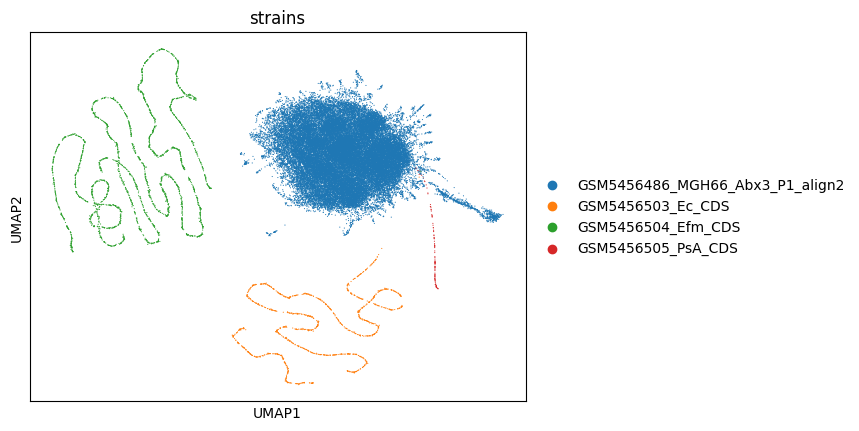

In [9]:
sc.tl.umap(data_gex)
sc.pl.umap(data_gex, color=["strains"])

### Removal of doublets and noise
Most of the cells express not more than ~250 genes per cell and are probably doublets, so they are removed

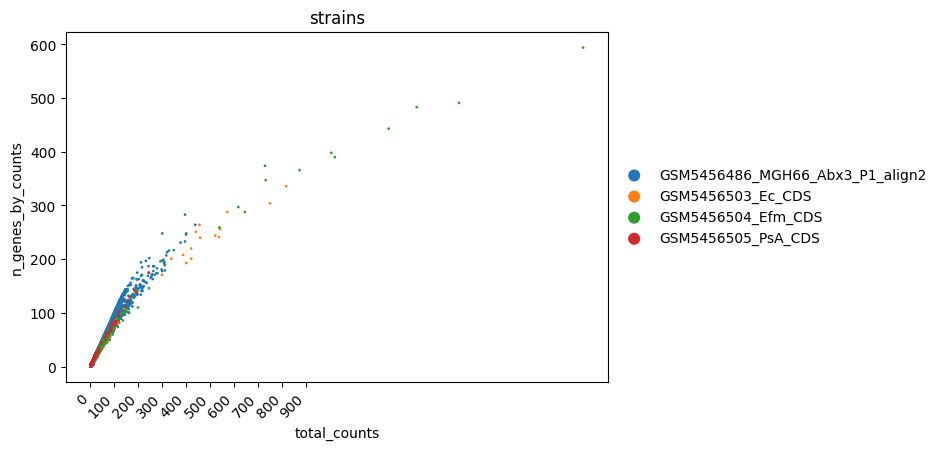

In [6]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

g = sc.pl.scatter(data_gex, x='total_counts', y='n_genes_by_counts', color="strains", show=False, size=15)
g.set_xticks(ticks=range(0, 1000, 100))
g.set_xticklabels(labels=range(0, 1000, 100), rotation=45, ha="right")
plt.show()

In [7]:
print('Original data shape:\t\t', data_gex.shape)
sc.pp.filter_cells(data_gex, max_counts=250)
print('Shape after doublet removal:\t', data_gex.shape)

Original data shape:		 (437964, 13536)
Shape after doublet removal:	 (437904, 13536)


### Split strain specific into 4 datasets

In [8]:
print('Original data shape (n x p):\t', data_gex.shape)
print('--------------------------------------------------')

data_gex_mgh = data_gex[data_gex.obs['strains'] == 'GSM5456486_MGH66_Abx3_P1_align2'].copy()
print('Original mgh data shape:\t', data_gex_mgh.shape)
sc.pp.filter_genes(data_gex_mgh, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_mgh, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_mgh.shape)
print('--------------------------------------------------')


data_gex_efm = data_gex[data_gex.obs['strains'] == 'GSM5456504_Efm_CDS'].copy()
print('original efm data shape:\t', data_gex_efm.shape)
sc.pp.filter_genes(data_gex_efm, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_efm.shape)
print('--------------------------------------------------')


data_gex_ec = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS'].copy()
print('original ec data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_genes(data_gex_ec, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_ec.shape)
print('--------------------------------------------------')


data_gex_psa = data_gex[data_gex.obs['strains'] == 'GSM5456505_PsA_CDS'].copy()
print('original psa data shape:\t', data_gex_psa.shape)
sc.pp.filter_genes(data_gex_psa, min_cells=1)
#sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_psa.shape)

Original data shape (n x p):	 (437904, 13536)
--------------------------------------------------
Original mgh data shape:	 (410110, 13536)
Strain specific genes shape:	 (410110, 4066)
--------------------------------------------------
original efm data shape:	 (9963, 13536)
Strain specific genes shape:	 (9963, 2337)
--------------------------------------------------
original ec data shape:		 (9639, 13536)
Strain specific genes shape:	 (9639, 3620)
--------------------------------------------------
original psa data shape:	 (8192, 13536)
Strain specific genes shape:	 (8192, 3478)


## Example of preprocessing on E. Coli
The other 3 strains can be found below

### Splitting into 3 datasets per strain
For each strain we now split into 3 different datasets based on different gene abundance levels:
1) All genes
2) High abundance genes (>=10 apperances)
3) Low abundance genes (<10 apperances)

In [9]:
filter, _ = sc.pp.filter_genes(data_gex_ec, min_cells=10, inplace=False)

In [10]:
ec_mudata = md.MuData({"all_genes": data_gex_ec.copy(), 
                       "high_abundance_genes": data_gex_ec[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_ec[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(ec_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(ec_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


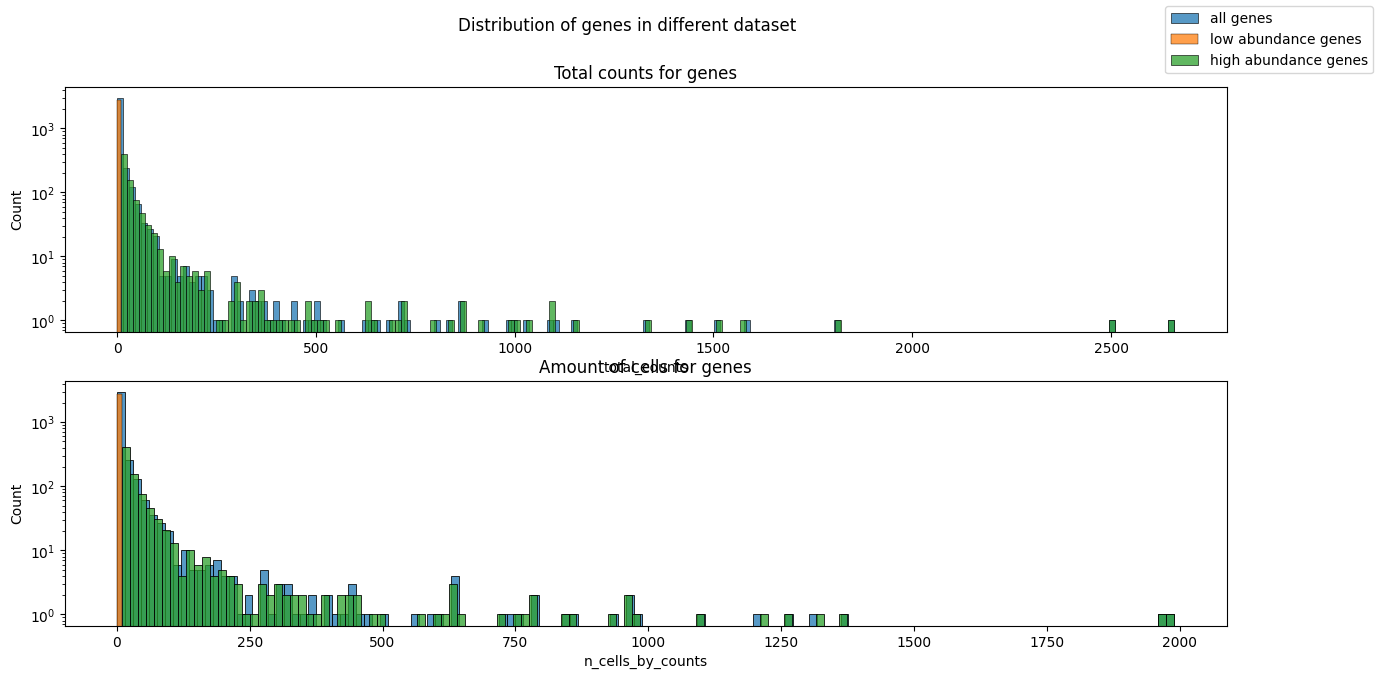

In [61]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(ec_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(ec_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(ec_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(ec_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(ec_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(ec_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_title("Total counts for genes")
axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

Text(0.5, 1.0, 'Distribution of reads in each cell')

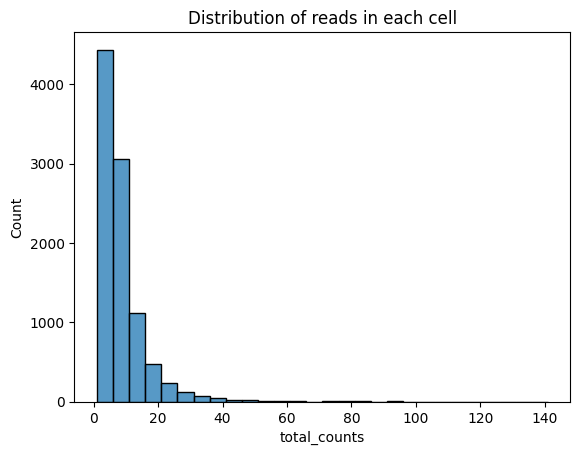

In [58]:
sns.histplot(ec_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
plt.title("Distribution of reads in each cell")

### Normalization & Variance stabilization

Several normalization methods and VSTs are applied and saved in different layers:
- Log1p normalization
- Scanpy's total sum normalization with target sum being median count
- Square root transformation
- (Scran normalization (https://www.sc-best-practices.org/preprocessing_visualization/normalization.html & https://github.com/sfortma2/scranPY/blob/main/scranPY_tutorial.ipynb) --> Can be found in ./scran.ipynb notebook)

In [52]:
for i in ec_mudata.mod:
    ec_mudata[i].layers["raw_counts"]  = ec_mudata[i].X
    ec_mudata[i].layers["log1p"]       = sc.pp.log1p(ec_mudata[i], copy=True).X
    ec_mudata[i].layers["sqrt_counts"] = np.sqrt(ec_mudata[i].X)
    ec_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(ec_mudata[i], target_sum=None, inplace=False)['X']
ec_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 9639 × 7240
  3 modalities
    all_genes:	9639 x 3620
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	9639 x 847
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	9639 x 2773
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'E. Coli All Genes Normalization & VST')

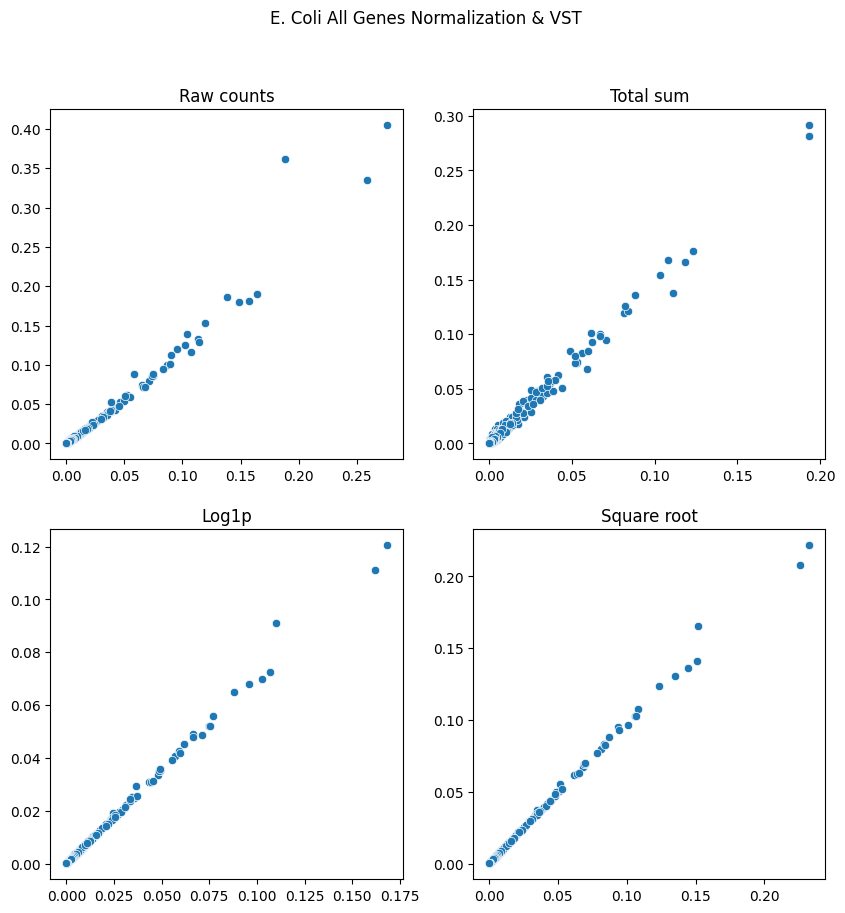

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("E. Coli All Genes Normalization & VST")

Text(0.5, 0.98, 'E. Coli Low And High Abundance Genes Normalization & VST')

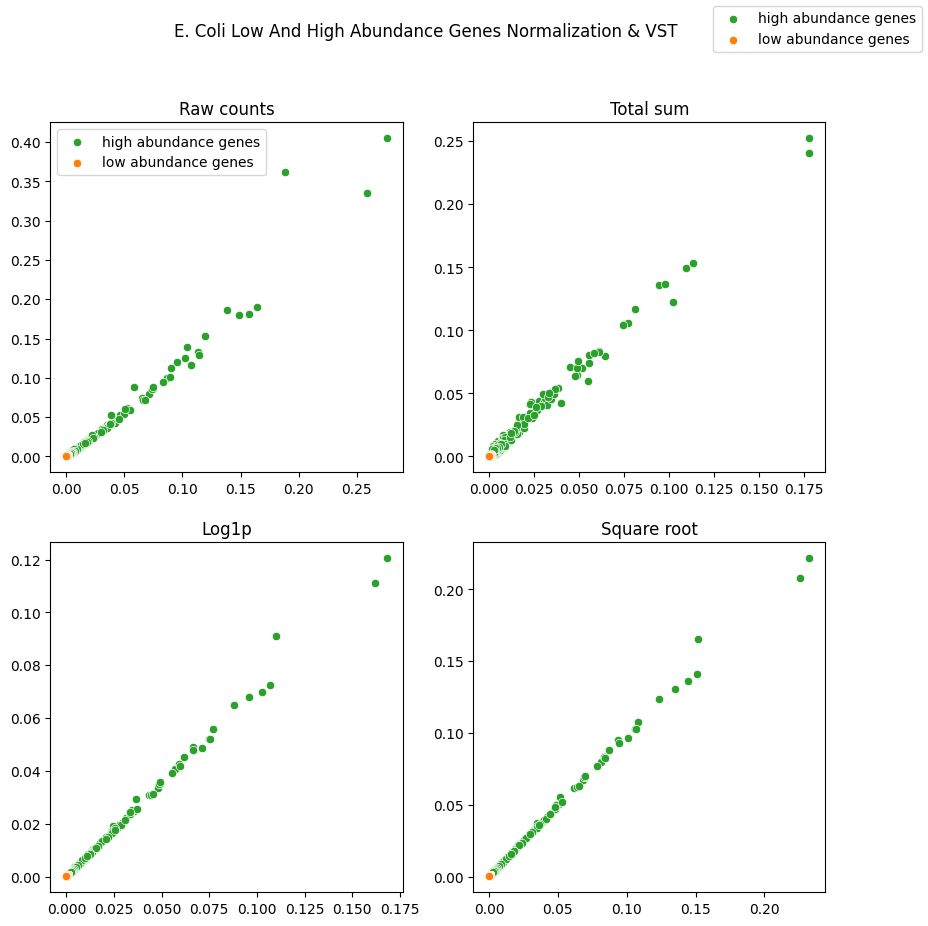

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("E. Coli Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'E. Coli Low Abundance Genes Normalization & VST')

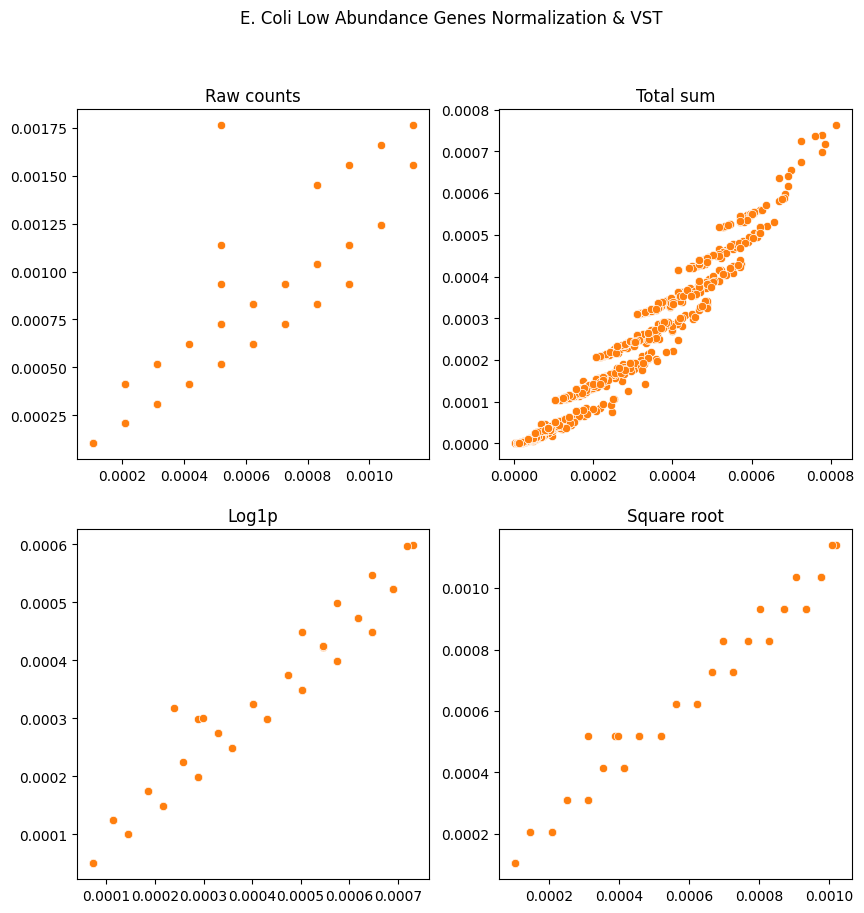

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(ec_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("E. Coli Low Abundance Genes Normalization & VST")

In [91]:
print(calc_sparsity(ec_mudata["all_genes"].X.A))
print(calc_sparsity(ec_mudata["low_abundance_genes"].X.A))
print(calc_sparsity(ec_mudata["high_abundance_genes"].X.A))

0.0022208637905745477
0.00026952053142983897
0.00860938192234347


## Efm

In [62]:
filter, _ = sc.pp.filter_genes(data_gex_efm, min_cells=10, inplace=False)

In [63]:
efm_mudata = md.MuData({"all_genes": data_gex_efm.copy(), 
                       "high_abundance_genes": data_gex_efm[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_efm[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(efm_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(efm_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


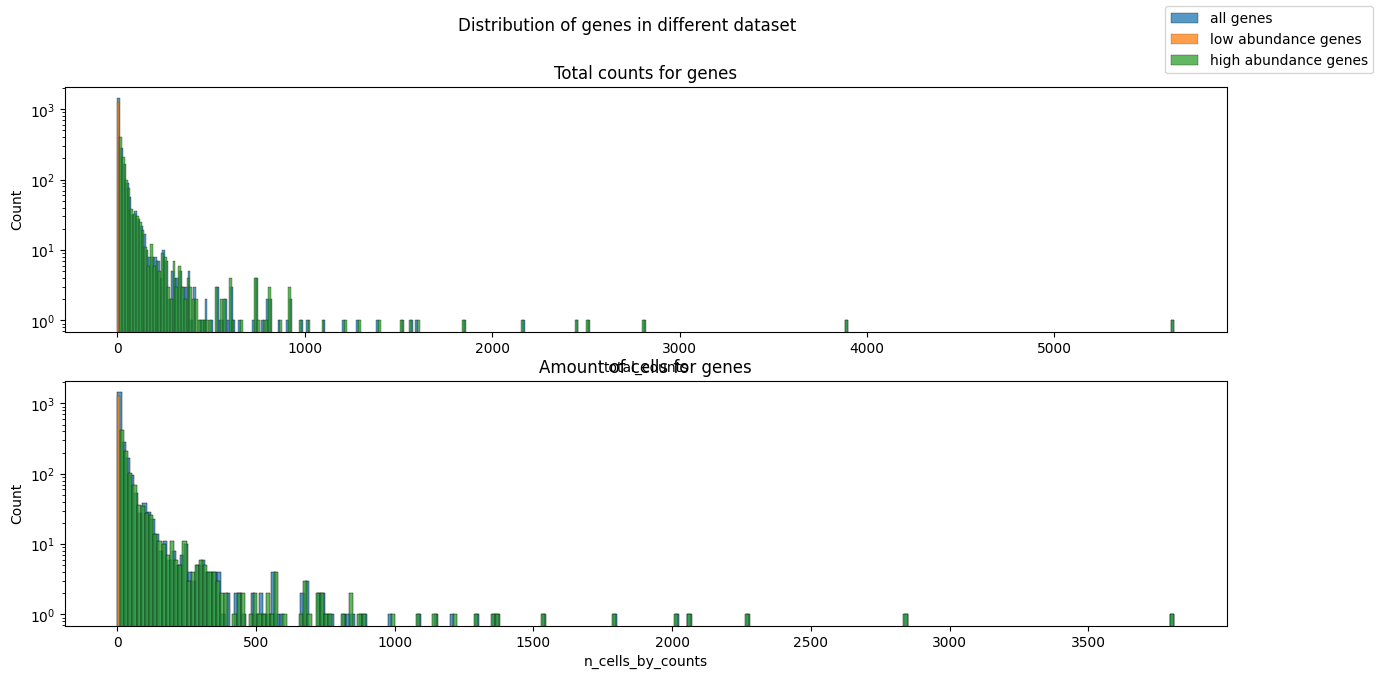

In [64]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(efm_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(efm_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(efm_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(efm_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(efm_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(efm_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_title("Total counts for genes")
axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

Text(0.5, 1.0, 'Distribution of reads in each cell')

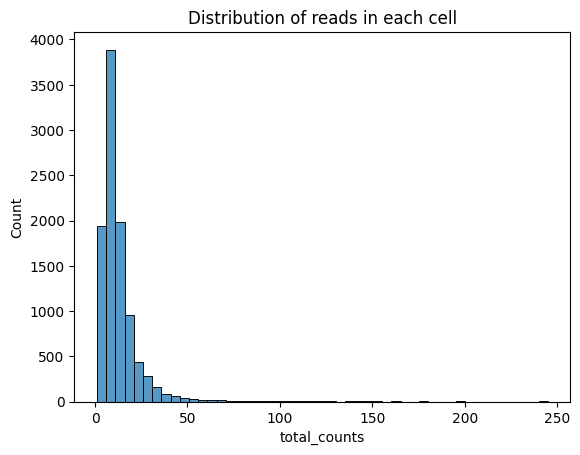

In [65]:
sns.histplot(efm_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
plt.title("Distribution of reads in each cell")

In [66]:
for i in efm_mudata.mod:
    efm_mudata[i].layers["raw_counts"]  = efm_mudata[i].X
    efm_mudata[i].layers["log1p"]       = sc.pp.log1p(efm_mudata[i], copy=True).X
    efm_mudata[i].layers["sqrt_counts"] = np.sqrt(efm_mudata[i].X)
    efm_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(efm_mudata[i], target_sum=None, inplace=False)['X']
efm_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 9963 × 4674
  3 modalities
    all_genes:	9963 x 2337
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	9963 x 1083
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	9963 x 1254
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Efm All Genes Normalization & VST')

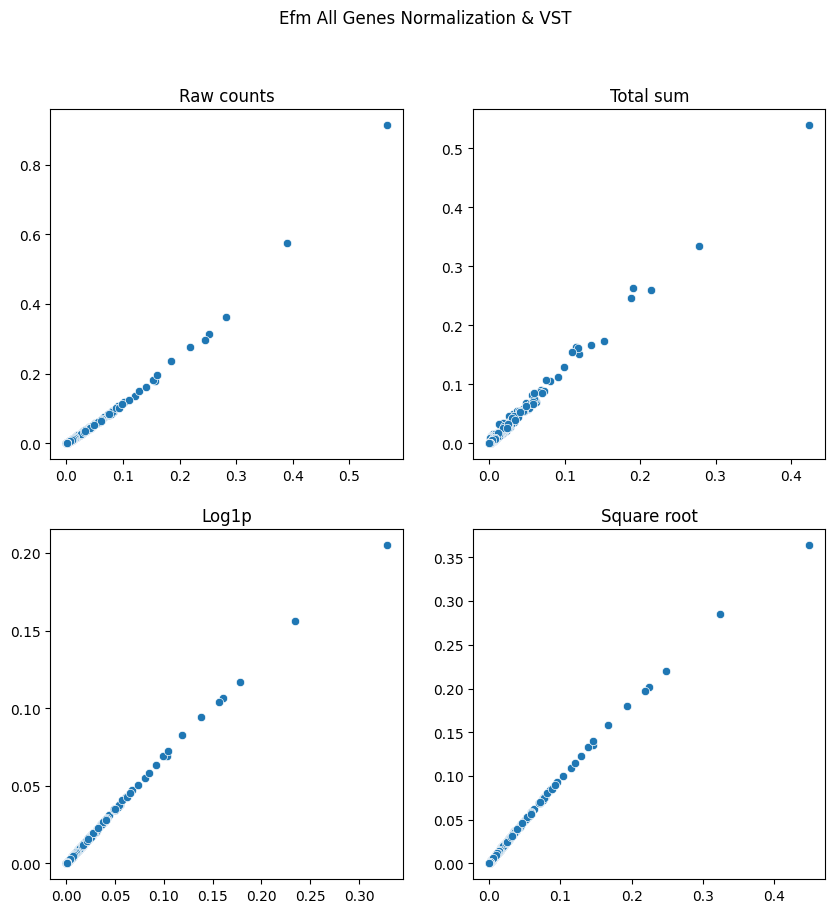

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Efm All Genes Normalization & VST")

Text(0.5, 0.98, 'Efm Low And High Abundance Genes Normalization & VST')

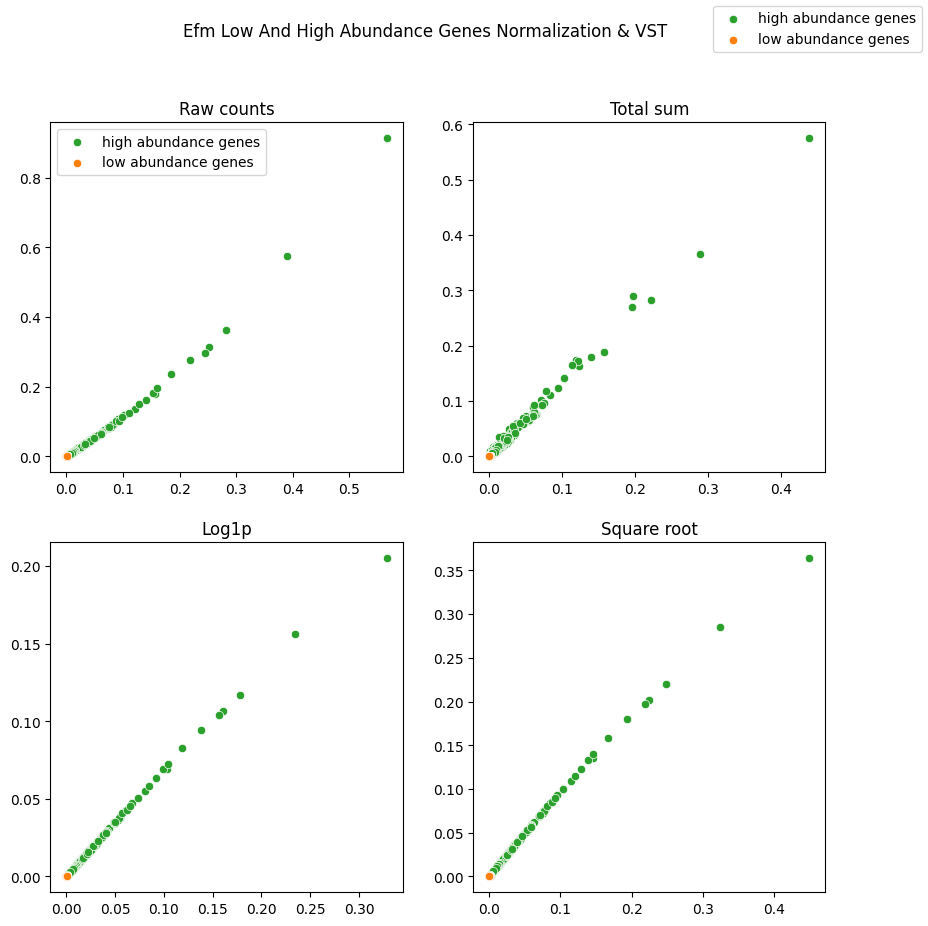

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Efm Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Efm Low Abundance Genes Normalization & VST')

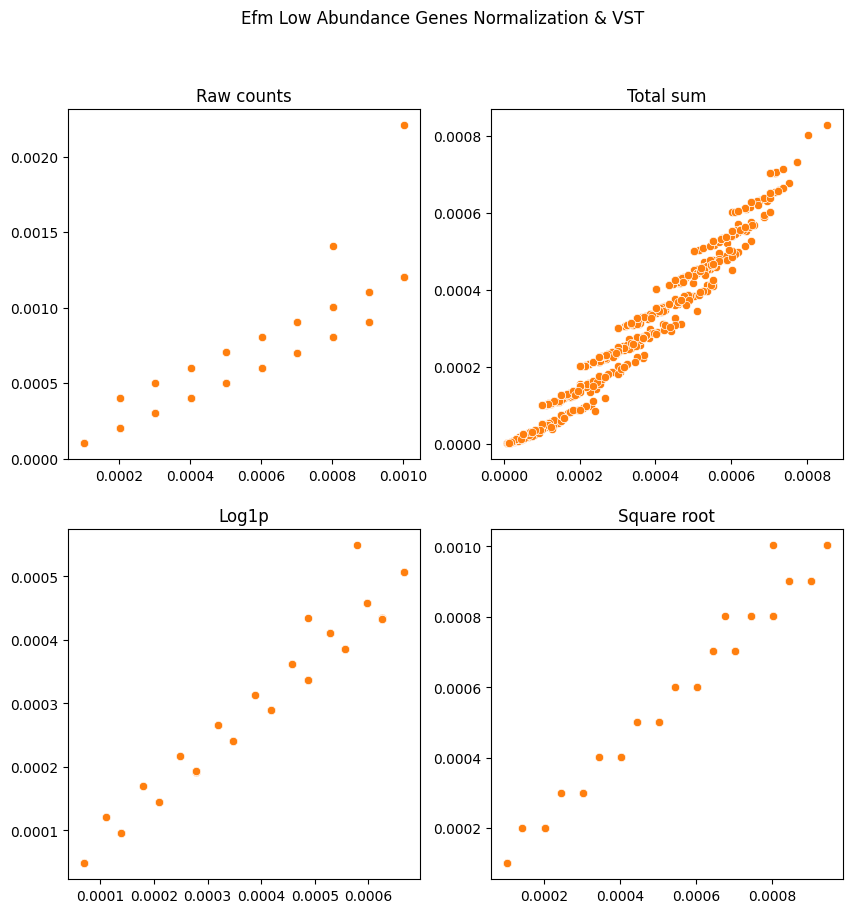

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(efm_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Efm Low Abundance Genes Normalization & VST")

In [92]:
print(calc_sparsity(efm_mudata["all_genes"].X.A))
print(calc_sparsity(efm_mudata["low_abundance_genes"].X.A))
print(calc_sparsity(efm_mudata["high_abundance_genes"].X.A))

0.0052294903208624155
0.00036018435676116466
0.010867634068769127


## Psa

In [71]:
filter, _ = sc.pp.filter_genes(data_gex_psa, min_cells=10, inplace=False)

In [72]:
psa_mudata = md.MuData({"all_genes": data_gex_psa.copy(), 
                       "high_abundance_genes": data_gex_psa[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_psa[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(psa_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(psa_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


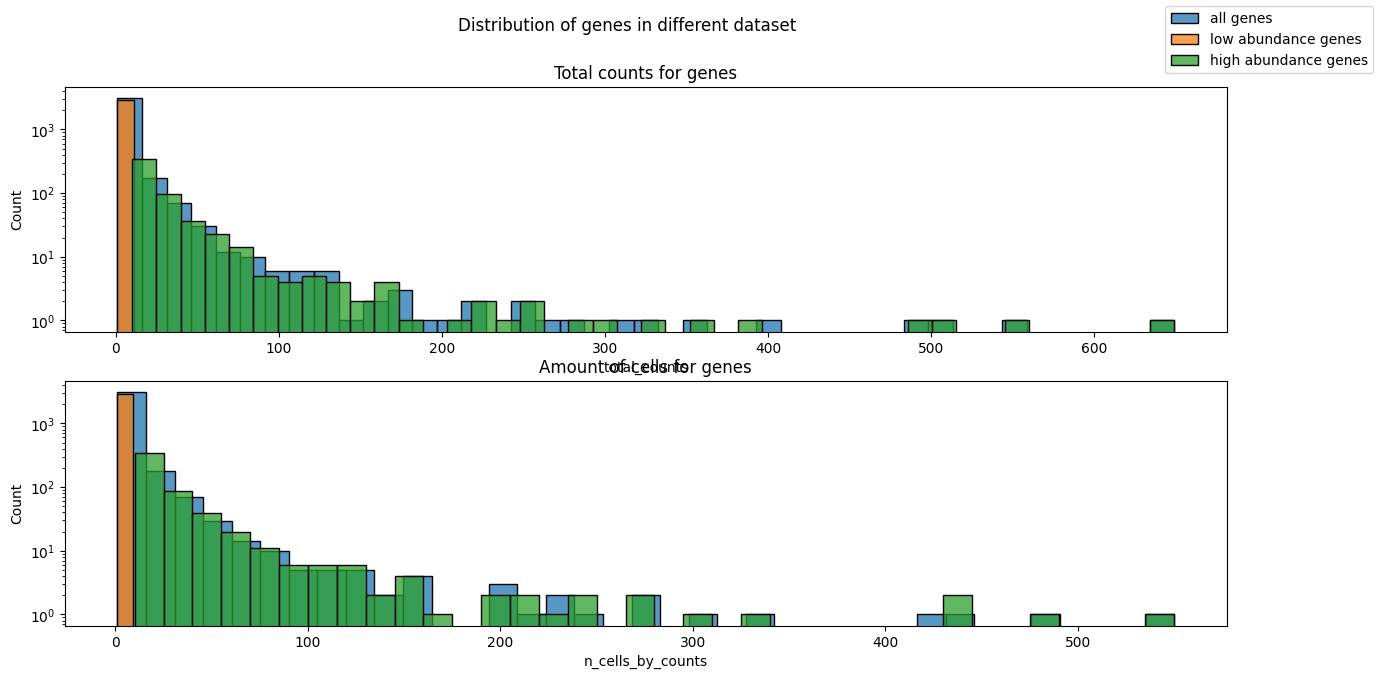

In [73]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(psa_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(psa_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(psa_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(psa_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(psa_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(psa_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_title("Total counts for genes")
axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

Text(0.5, 1.0, 'Distribution of reads in each cell')

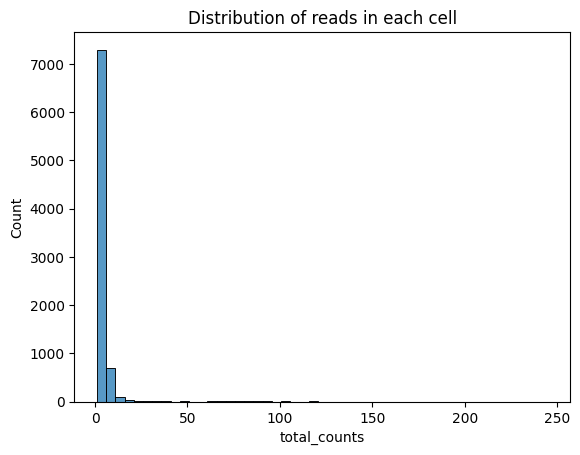

In [74]:
sns.histplot(psa_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
plt.title("Distribution of reads in each cell")

In [76]:
for i in efm_mudata.mod:
    psa_mudata[i].layers["raw_counts"]  = psa_mudata[i].X
    psa_mudata[i].layers["log1p"]       = sc.pp.log1p(psa_mudata[i], copy=True).X
    psa_mudata[i].layers["sqrt_counts"] = np.sqrt(psa_mudata[i].X)
    psa_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(psa_mudata[i], target_sum=None, inplace=False)['X']
psa_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 8192 × 6956
  3 modalities
    all_genes:	8192 x 3478
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	8192 x 545
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	8192 x 2933
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Psa All Genes Normalization & VST')

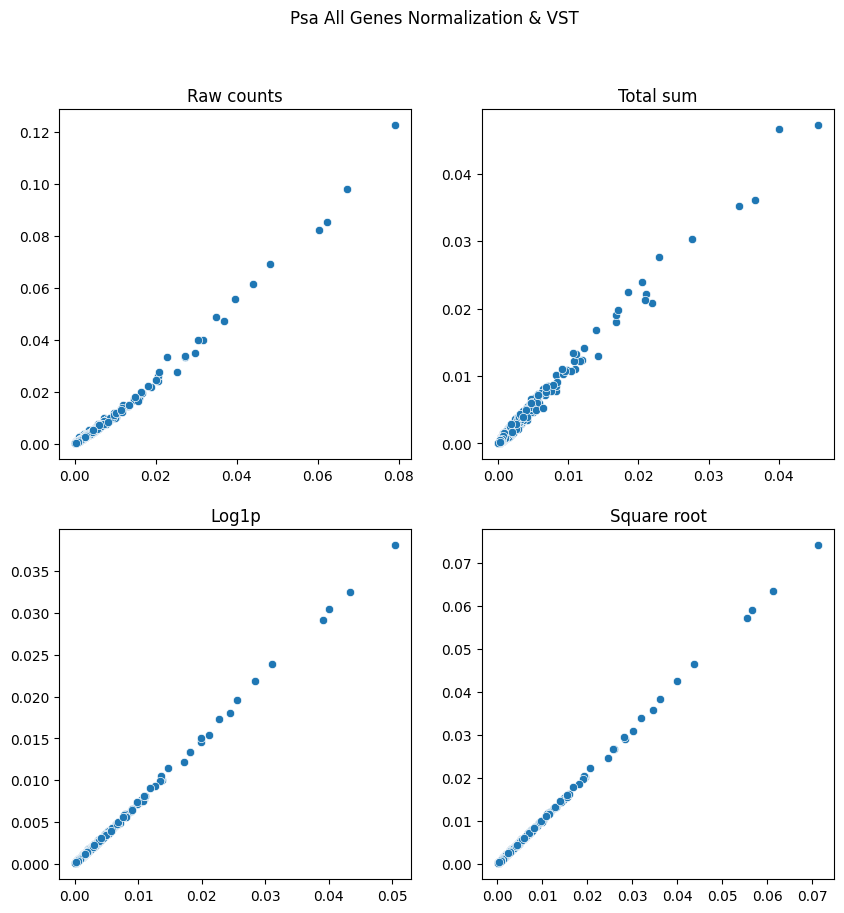

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Psa All Genes Normalization & VST")

Text(0.5, 0.98, 'Psa Low And High Abundance Genes Normalization & VST')

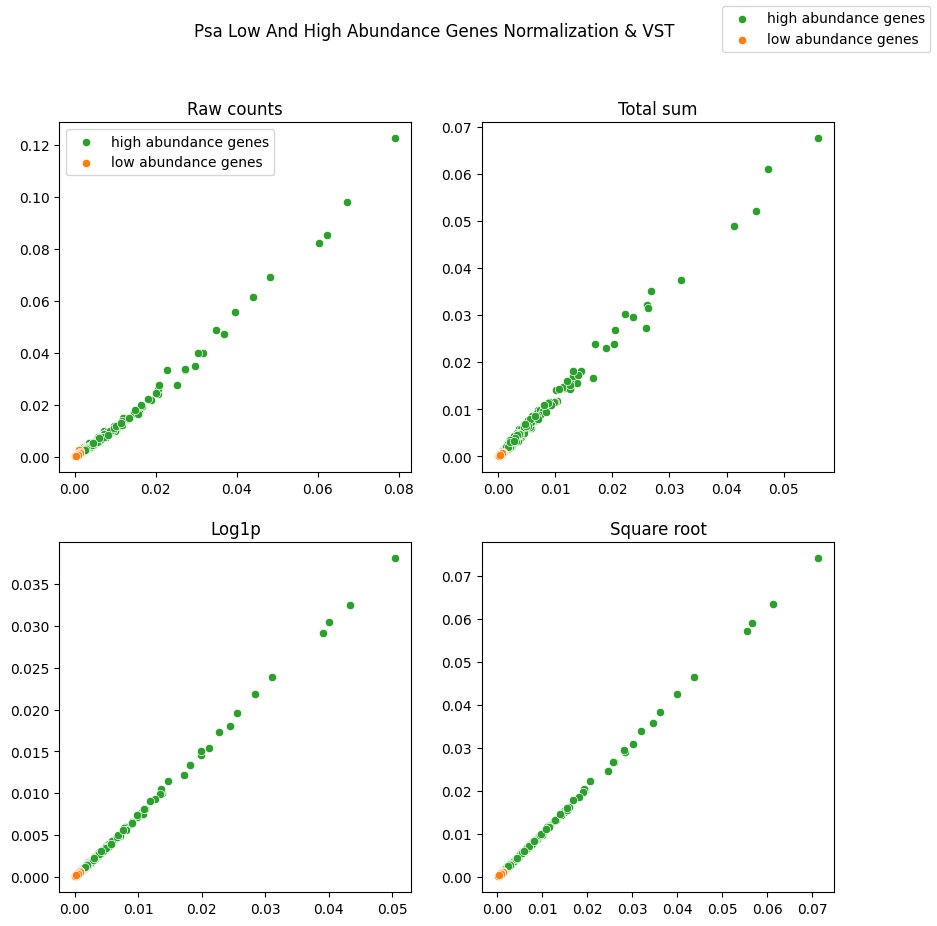

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Psa Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Psa Low Abundance Genes Normalization & VST')

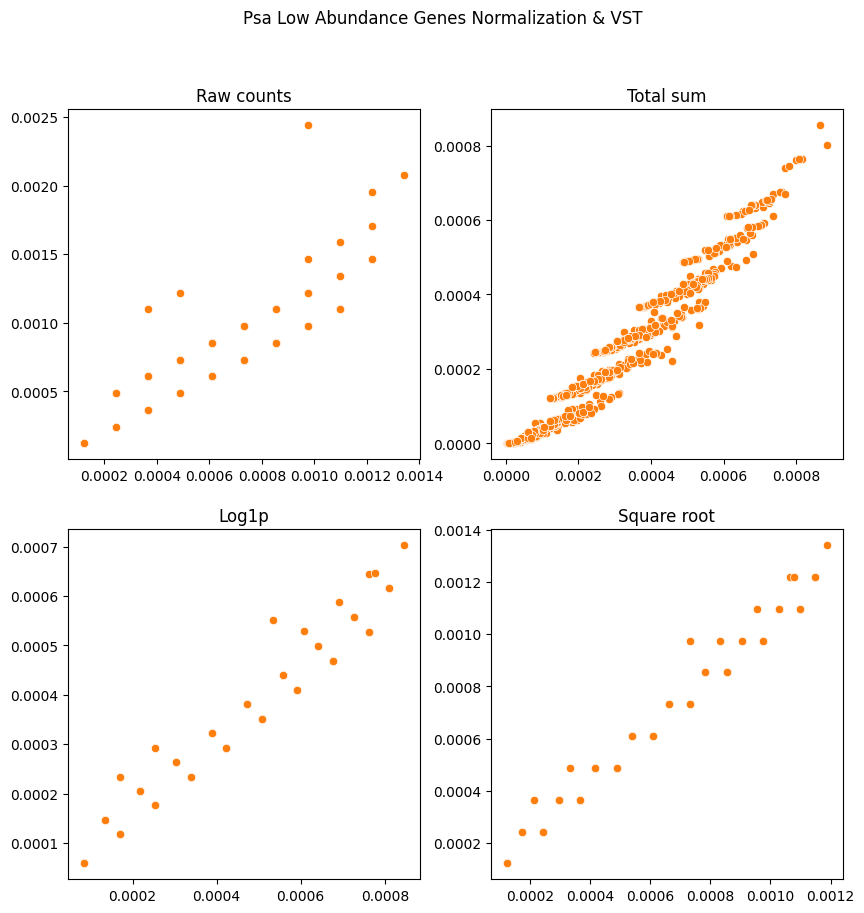

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(psa_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Psa Low Abundance Genes Normalization & VST")

In [93]:
print(calc_sparsity(psa_mudata["all_genes"].X.A))
print(calc_sparsity(psa_mudata["low_abundance_genes"].X.A))
print(calc_sparsity(psa_mudata["high_abundance_genes"].X.A))

0.0009909877151919207
0.00031102333628111147
0.004650318950688073


## Mgh

In [80]:
filter, _ = sc.pp.filter_genes(data_gex_mgh, min_cells=10, inplace=False)

In [81]:
mgh_mudata = md.MuData({"all_genes": data_gex_mgh.copy(), 
                       "high_abundance_genes": data_gex_mgh[:, filter].copy(), 
                       "low_abundance_genes":  data_gex_mgh[:, ~filter].copy()})

sc.pp.calculate_qc_metrics(mgh_mudata["all_genes"],            var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(mgh_mudata["high_abundance_genes"], var_type="genes", percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(mgh_mudata["low_abundance_genes"],  var_type="genes", percent_top=None, log1p=False, inplace=True)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


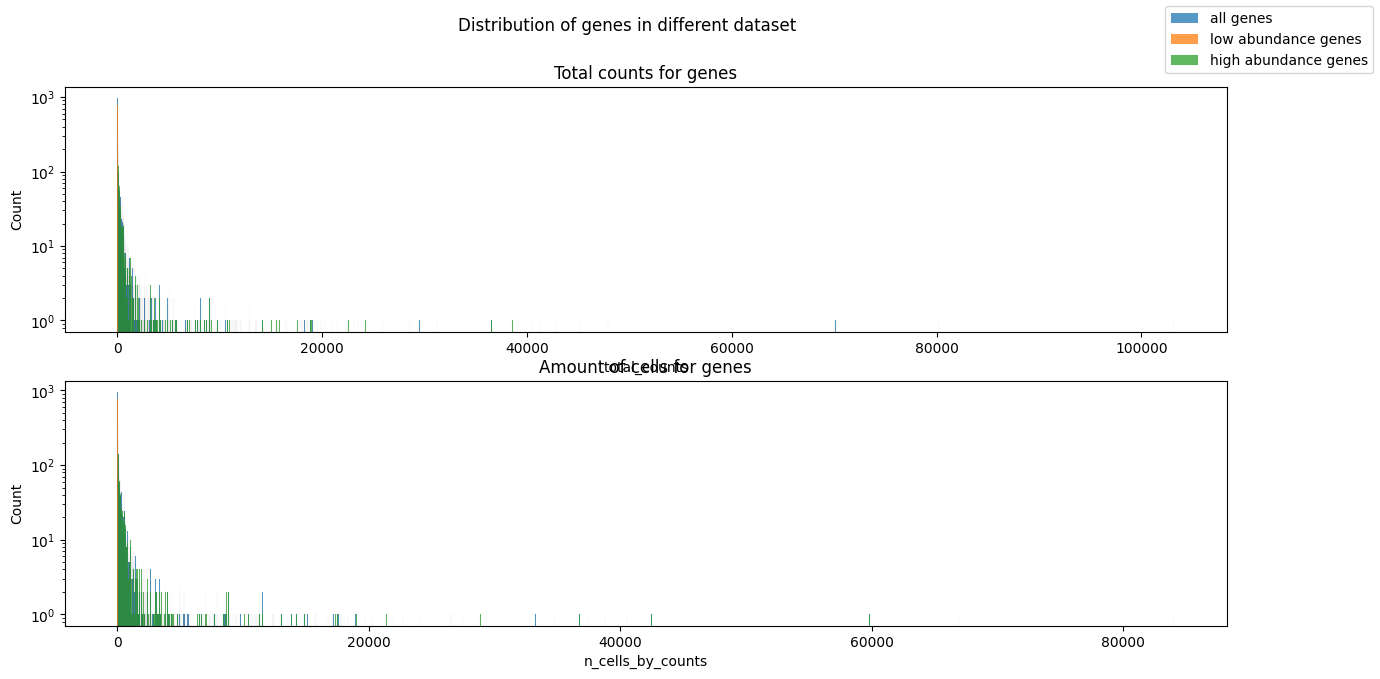

In [82]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

sns.histplot(mgh_mudata["all_genes"].var["total_counts"], binwidth=15, kde=False, color="C0", label="all genes", ax=axes[0])
sns.histplot(mgh_mudata["low_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C1", label="low abundance genes", ax=axes[0])
sns.histplot(mgh_mudata["high_abundance_genes"].var["total_counts"], binwidth=15, kde=False, color="C2", label="high abundance genes", ax=axes[0])

sns.histplot(mgh_mudata["all_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C0", ax=axes[1])
sns.histplot(mgh_mudata["low_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C1", ax=axes[1])
sns.histplot(mgh_mudata["high_abundance_genes"].var["n_cells_by_counts"], binwidth=15, kde=False, color="C2", ax=axes[1])

axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_title("Total counts for genes")
axes[1].set_title("Amount of cells for genes")

fig.suptitle("Distribution of genes in different dataset")
fig.legend()

Text(0.5, 1.0, 'Distribution of reads in each cell')

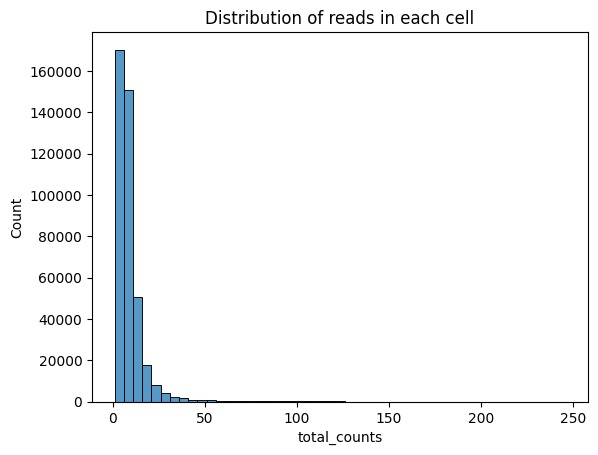

In [83]:
sns.histplot(mgh_mudata["all_genes"].obs["total_counts"], binwidth=5, kde=False, color="C0", label="all genes")
plt.title("Distribution of reads in each cell")

In [84]:
for i in efm_mudata.mod:
    mgh_mudata[i].layers["raw_counts"]  = mgh_mudata[i].X
    mgh_mudata[i].layers["log1p"]       = sc.pp.log1p(mgh_mudata[i], copy=True).X
    mgh_mudata[i].layers["sqrt_counts"] = np.sqrt(mgh_mudata[i].X)
    mgh_mudata[i].layers["norm_counts"] = sc.pp.normalize_total(mgh_mudata[i], target_sum=None, inplace=False)['X']
mgh_mudata

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


MuData object with n_obs × n_vars = 410110 × 8132
  3 modalities
    all_genes:	410110 x 4066
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    high_abundance_genes:	410110 x 3294
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'
    low_abundance_genes:	410110 x 772
      obs:	'strains', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
      layers:	'raw_counts', 'log1p', 'sqrt_counts', 'norm_counts'

Text(0.5, 0.98, 'Mgh All Genes Normalization & VST')

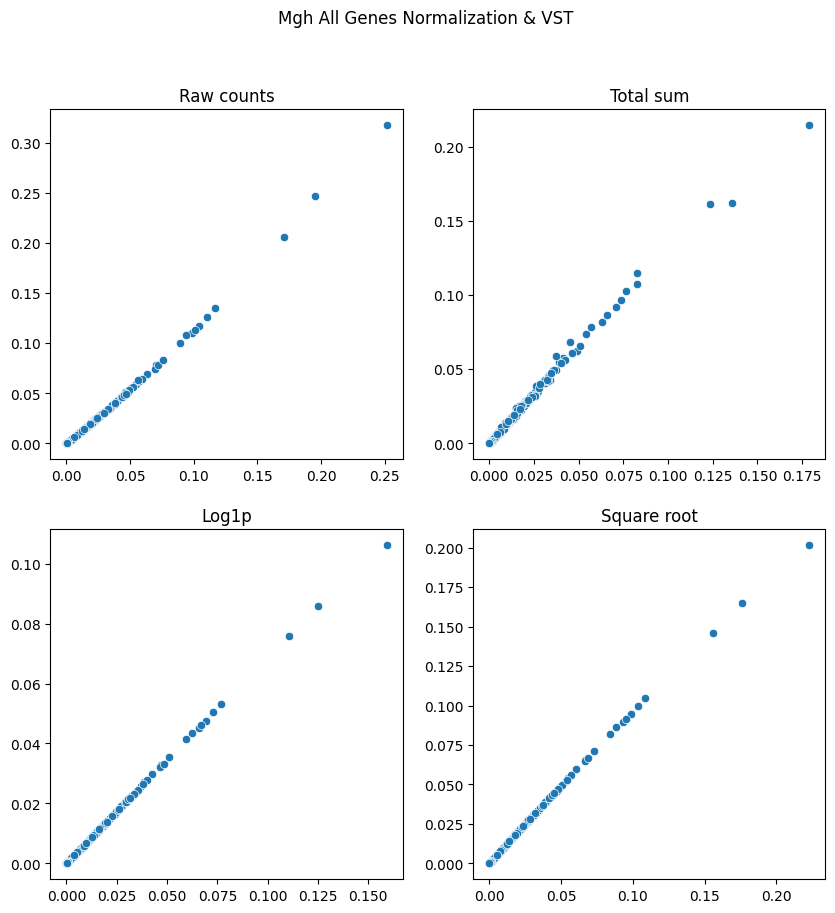

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].X.A, axis=0), 
                ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['norm_counts'].A, axis=0), 
                ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['log1p'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["all_genes"].layers['sqrt_counts'].A, axis=0), 
                ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Mgh All Genes Normalization & VST")

Text(0.5, 0.98, 'Mgh Low And High Abundance Genes Normalization & VST')

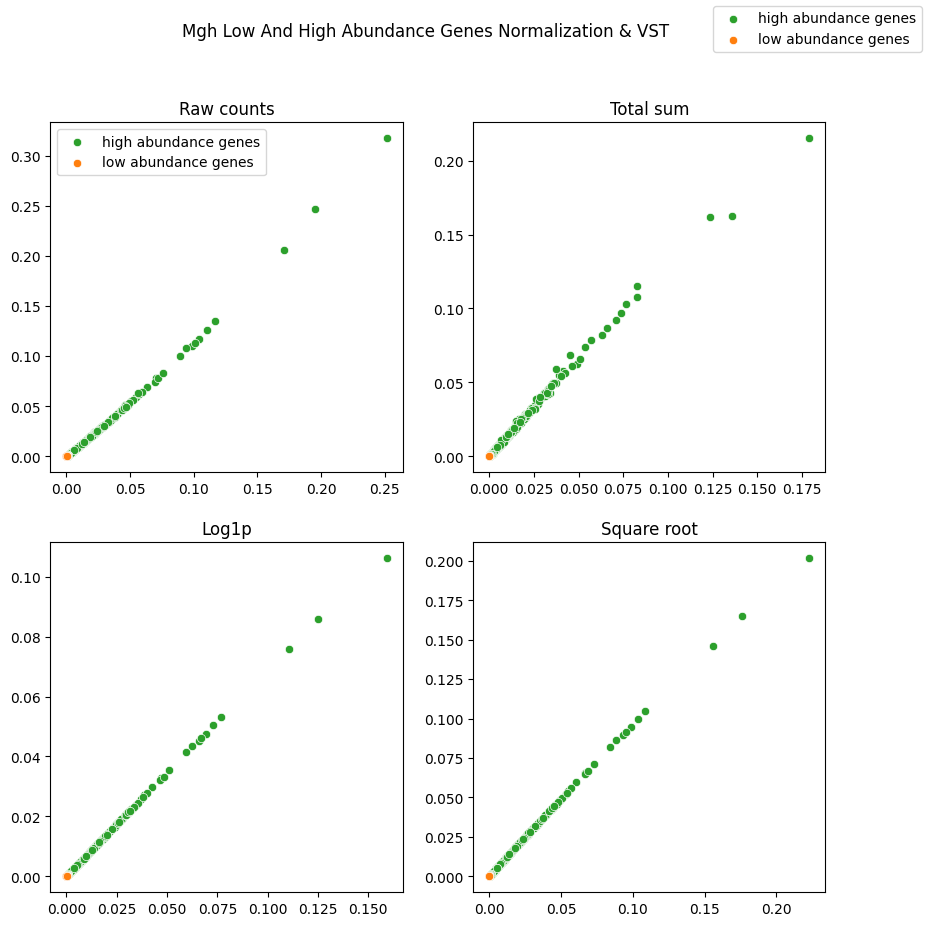

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].X.A, axis=0), 
                color="C2", label="high abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C2", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C2", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["high_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C2", ax=axes[1][1])


sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", label="low abundance genes", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.legend()
fig.suptitle("Mgh Low And High Abundance Genes Normalization & VST")

Text(0.5, 0.98, 'Mgh Low Abundance Genes Normalization & VST')

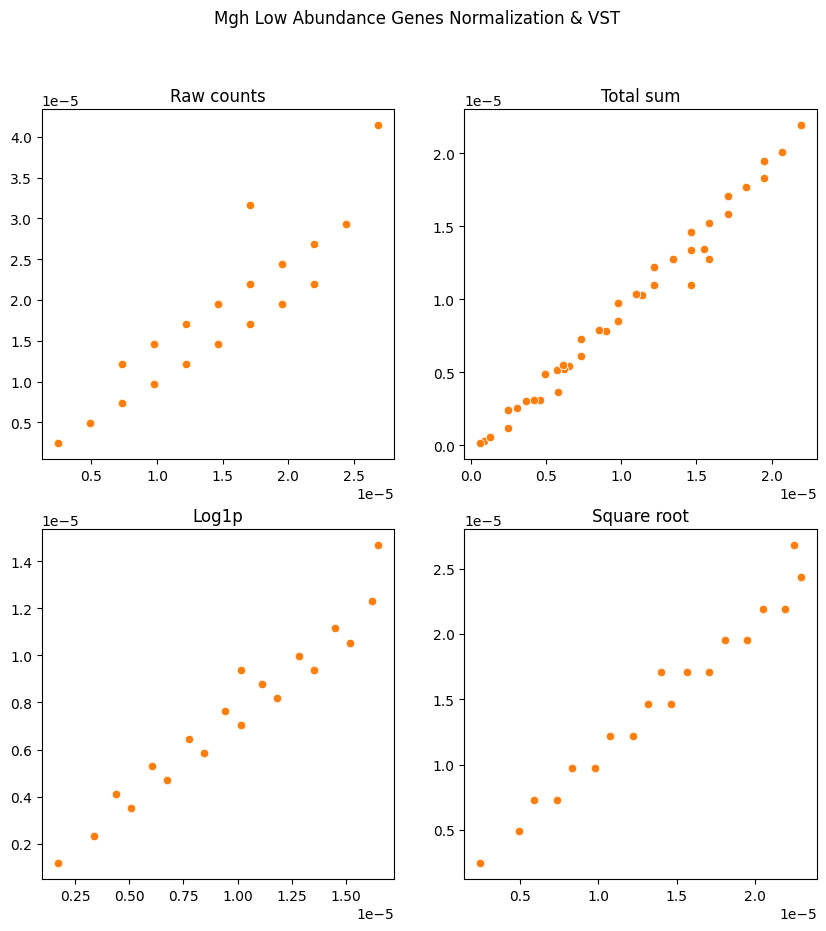

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].X.A, axis=0), 
                color="C1", ax=axes[0][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['norm_counts'].A, axis=0), 
                color="C1", ax=axes[0][1])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['log1p'].A, axis=0), 
                color="C1", ax=axes[1][0])

sns.scatterplot(x=np.mean(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                y=np.var(mgh_mudata["low_abundance_genes"].layers['sqrt_counts'].A, axis=0), 
                color="C1", ax=axes[1][1])


axes[0,0].set_title("Raw counts")
axes[0,1].set_title("Total sum")
axes[1,0].set_title("Log1p")
axes[1,1].set_title("Square root")
fig.suptitle("Mgh Low Abundance Genes Normalization & VST")

In [94]:
print(calc_sparsity(mgh_mudata["all_genes"].X.A))
print(calc_sparsity(mgh_mudata["low_abundance_genes"].X.A))
print(calc_sparsity(mgh_mudata["high_abundance_genes"].X.A))

0.002040386318917736
8.65747759068305e-06
0.002516553491202036


In [95]:
ec_mudata.write("../data/preprocessed/ec_mudata_prepro.h5mu")
efm_mudata.write("../data/preprocessed/efm_mudata_prepro.h5mu")
psa_mudata.write("../data/preprocessed/psa_mudata_prepro.h5mu")
mgh_mudata.write("../data/preprocessed/mgh_mudata_prepro.h5mu")

#sc.write(filename='../data/preprocessed/mgh_prepro.h5ad', adata=data_gex_mgh)
#sc.write(filename='../data/preprocessed/efm_prepro.h5ad', adata=data_gex_efm)
#sc.write(filename='../data/preprocessed/ec_prepro.h5ad', adata=data_gex_ec)
#sc.write(filename='../data/preprocessed/psa_prepro.h5ad', adata=data_gex_psa)

/home/jan/anaconda3/envs/bacdrop/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
